# Traditional Collaborative Filtering
## User-Based and Item-Based Collaborative Filtering Implementation

**Objectives:**
- Implement User-based Collaborative Filtering
- Implement Item-based Collaborative Filtering  
- Compare performance with baseline models
- Optimize computational efficiency

**Data Source:** Processed data from EDA notebook

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr
import pickle
import time
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Data Loading and Preparation

In [2]:
# Load processed data from EDA
def load_processed_data():
    """Load all processed datasets from EDA notebook"""
    try:
        # Load the split datasets
        train_data = pd.read_csv('../data/processed/train_data.csv')
        val_data = pd.read_csv('../data/processed/val_data.csv')
        test_data = pd.read_csv('../data/processed/test_data.csv')
        
        # Load feature datasets
        user_features = pd.read_csv('../data/processed/user_features.csv')
        movie_features = pd.read_csv('../data/processed/movie_features.csv')
        
        print(f"✅ Data loaded successfully!")
        print(f"📊 Train: {len(train_data):,} ratings")
        print(f"📊 Validation: {len(val_data):,} ratings")
        print(f"📊 Test: {len(test_data):,} ratings")
        print(f"👥 Users: {len(user_features):,}")
        print(f"🎬 Movies: {len(movie_features):,}")
        
        return train_data, val_data, test_data, user_features, movie_features
    
    except FileNotFoundError as e:
        print(f"❌ Error loading data: {e}")
        print("📝 Please run EDA notebook first to generate processed data")
        return None, None, None, None, None

# Load data
train_data, val_data, test_data, user_features, movie_features = load_processed_data()

✅ Data loaded successfully!
📊 Train: 70,585 ratings
📊 Validation: 15,125 ratings
📊 Test: 15,126 ratings
👥 Users: 610
🎬 Movies: 9,724


In [3]:
# Create utility matrices for collaborative filtering
def create_utility_matrix(data: pd.DataFrame, fill_value=0):
    """Create user-item utility matrix from ratings data"""
    # Create pivot table
    utility_matrix = data.pivot_table(
        index='userId', 
        columns='movieId', 
        values='rating',
        fill_value=fill_value
    )
    
    print(f"📊 Utility Matrix Shape: {utility_matrix.shape}")
    print(f"📈 Sparsity: {(utility_matrix == 0).sum().sum() / (utility_matrix.shape[0] * utility_matrix.shape[1]):.4f}")
    
    return utility_matrix

# Create utility matrices
print("🔧 Creating utility matrices...")
train_matrix = create_utility_matrix(train_data)
print(f"✅ Training matrix created: {train_matrix.shape}")

🔧 Creating utility matrices...
📊 Utility Matrix Shape: (453, 7056)
📈 Sparsity: 0.9779
✅ Training matrix created: (453, 7056)


## 2. User-Based Collaborative Filtering Implementation

In [4]:
class UserBasedCF:
    """
    User-Based Collaborative Filtering Recommender
    
    Finds similar users based on rating patterns and makes recommendations
    based on what similar users liked.
    """
    
    def __init__(self, similarity_metric='cosine', k_neighbors=50, min_common_items=5):
        """
        Initialize User-Based CF model
        
        Args:
            similarity_metric: 'cosine' or 'pearson'
            k_neighbors: Number of similar users to consider
            min_common_items: Minimum common items for similarity calculation
        """
        self.similarity_metric = similarity_metric
        self.k_neighbors = k_neighbors
        self.min_common_items = min_common_items
        self.user_similarity = None
        self.utility_matrix = None
        self.user_means = None
        
    def fit(self, utility_matrix: pd.DataFrame):
        """
        Train the model by computing user similarity matrix
        
        Args:
            utility_matrix: User-item rating matrix
        """
        print(f"🔧 Training User-Based CF with {self.similarity_metric} similarity...")
        start_time = time.time()
        
        self.utility_matrix = utility_matrix.copy()
        
        # Calculate user means (excluding zero ratings)
        self.user_means = {}
        for user_id in utility_matrix.index:
            user_ratings = utility_matrix.loc[user_id]
            non_zero_ratings = user_ratings[user_ratings > 0]
            self.user_means[user_id] = non_zero_ratings.mean() if len(non_zero_ratings) > 0 else 0
        
        # Compute user similarity matrix
        self.user_similarity = self._compute_user_similarity()
        
        training_time = time.time() - start_time
        print(f"✅ Training completed in {training_time:.2f} seconds")
        print(f"📊 Similarity matrix shape: {self.user_similarity.shape}")
        
    def _compute_user_similarity(self):
        """
        Compute pairwise user similarity matrix
        """
        n_users = len(self.utility_matrix.index)
        similarity_matrix = np.zeros((n_users, n_users))
        
        users = list(self.utility_matrix.index)
        
        print(f"🔄 Computing similarity for {n_users} users...")
        
        for i, user1 in enumerate(users):
            if i % 100 == 0:
                print(f"  Progress: {i}/{n_users} users processed")
                
            for j, user2 in enumerate(users[i:], i):
                if i == j:
                    similarity_matrix[i, j] = 1.0
                else:
                    sim = self._calculate_similarity(user1, user2)
                    similarity_matrix[i, j] = sim
                    similarity_matrix[j, i] = sim  # Symmetric matrix
        
        # Convert to DataFrame for easier indexing
        return pd.DataFrame(similarity_matrix, index=users, columns=users)
    
    def _calculate_similarity(self, user1, user2):
        """
        Calculate similarity between two users
        """
        # Get ratings for both users
        user1_ratings = self.utility_matrix.loc[user1]
        user2_ratings = self.utility_matrix.loc[user2]
        
        # Find common items (non-zero ratings for both users)
        common_items = (user1_ratings > 0) & (user2_ratings > 0)
        
        if common_items.sum() < self.min_common_items:
            return 0.0
        
        # Get common ratings
        common_user1 = user1_ratings[common_items]
        common_user2 = user2_ratings[common_items]
        
        if self.similarity_metric == 'cosine':
            # Cosine similarity
            return self._cosine_similarity(common_user1.values, common_user2.values)
        elif self.similarity_metric == 'pearson':
            # Pearson correlation
            if len(common_user1) < 2:
                return 0.0
            corr, _ = pearsonr(common_user1, common_user2)
            return corr if not np.isnan(corr) else 0.0
        else:
            raise ValueError(f"Unknown similarity metric: {self.similarity_metric}")
    
    def _cosine_similarity(self, vector1, vector2):
        """
        Calculate cosine similarity between two vectors
        """
        dot_product = np.dot(vector1, vector2)
        norm1 = np.linalg.norm(vector1)
        norm2 = np.linalg.norm(vector2)
        
        if norm1 == 0 or norm2 == 0:
            return 0.0
        
        return dot_product / (norm1 * norm2)
    
    def predict(self, user_id, movie_id):
        """
        Predict rating for a user-movie pair
        
        Args:
            user_id: User ID
            movie_id: Movie ID
            
        Returns:
            Predicted rating
        """
        if user_id not in self.utility_matrix.index:
            return self.user_means.get(user_id, 3.0)  # Global average fallback
        
        if movie_id not in self.utility_matrix.columns:
            return self.user_means.get(user_id, 3.0)  # User average fallback
        
        # Get similar users
        similar_users = self._get_similar_users(user_id)
        
        if not similar_users:
            return self.user_means.get(user_id, 3.0)
        
        # Calculate weighted average prediction
        numerator = 0
        denominator = 0
        
        user_mean = self.user_means[user_id]
        
        for similar_user, similarity in similar_users:
            similar_user_rating = self.utility_matrix.loc[similar_user, movie_id]
            
            if similar_user_rating > 0:  # User has rated this movie
                similar_user_mean = self.user_means[similar_user]
                
                # Mean-centered prediction
                numerator += similarity * (similar_user_rating - similar_user_mean)
                denominator += abs(similarity)
        
        if denominator == 0:
            return user_mean
        
        prediction = user_mean + (numerator / denominator)
        
        # Clip to valid rating range
        return np.clip(prediction, 0.5, 5.0)
    
    def _get_similar_users(self, user_id):
        """
        Get k most similar users to the given user
        
        Returns:
            List of (user_id, similarity) tuples
        """
        if user_id not in self.user_similarity.index:
            return []
        
        # Get similarities for this user
        user_similarities = self.user_similarity.loc[user_id]
        
        # Remove self-similarity
        user_similarities = user_similarities.drop(user_id)
        
        # Sort by similarity and take top k
        similar_users = user_similarities.sort_values(ascending=False).head(self.k_neighbors)
        
        # Filter out users with very low similarity
        similar_users = similar_users[similar_users > 0.1]
        
        return [(user, sim) for user, sim in similar_users.items()]
    
    def recommend(self, user_id, n_recommendations=10, exclude_seen=True):
        """
        Generate top-N recommendations for a user
        
        Args:
            user_id: User ID
            n_recommendations: Number of recommendations
            exclude_seen: Whether to exclude movies user has already rated
            
        Returns:
            List of (movie_id, predicted_rating) tuples
        """
        if user_id not in self.utility_matrix.index:
            print(f"⚠️  User {user_id} not found in training data")
            return []
        
        # Get all movies
        all_movies = self.utility_matrix.columns
        
        if exclude_seen:
            # Exclude movies user has already rated
            user_ratings = self.utility_matrix.loc[user_id]
            unseen_movies = user_ratings[user_ratings == 0].index
        else:
            unseen_movies = all_movies
        
        # Predict ratings for unseen movies
        predictions = []
        for movie_id in unseen_movies:
            predicted_rating = self.predict(user_id, movie_id)
            predictions.append((movie_id, predicted_rating))
        
        # Sort by predicted rating and return top N
        predictions.sort(key=lambda x: x[1], reverse=True)
        
        return predictions[:n_recommendations]

print("✅ UserBasedCF class defined successfully!")

✅ UserBasedCF class defined successfully!


In [5]:
# Train User-Based CF model
print("🚀 Training User-Based Collaborative Filtering...")

# Start with a smaller subset for testing (first 100 users)
small_train_matrix = train_matrix.iloc[:100, :500]  # 100 users, 500 movies

# Initialize and train model
user_cf = UserBasedCF(
    similarity_metric='cosine',
    k_neighbors=20,
    min_common_items=3
)

user_cf.fit(small_train_matrix)

print("✅ User-Based CF training completed!")

🚀 Training User-Based Collaborative Filtering...
🔧 Training User-Based CF with cosine similarity...
🔄 Computing similarity for 100 users...
  Progress: 0/100 users processed
✅ Training completed in 0.81 seconds
📊 Similarity matrix shape: (100, 100)
✅ User-Based CF training completed!
✅ Training completed in 0.81 seconds
📊 Similarity matrix shape: (100, 100)
✅ User-Based CF training completed!


In [6]:
# Test prediction functionality
print("🧪 Testing User-Based CF predictions...")

# Get a sample user and movie
sample_user = small_train_matrix.index[0]
sample_movie = small_train_matrix.columns[0]

print(f"👤 Sample User: {sample_user}")
print(f"🎬 Sample Movie: {sample_movie}")

# Make prediction
prediction = user_cf.predict(sample_user, sample_movie)
print(f"⭐ Predicted Rating: {prediction:.2f}")

# Get actual rating if available
actual_rating = small_train_matrix.loc[sample_user, sample_movie]
print(f"⭐ Actual Rating: {actual_rating}")

# Generate recommendations
print(f"\n🎯 Top 5 recommendations for User {sample_user}:")
recommendations = user_cf.recommend(sample_user, n_recommendations=5)

for i, (movie_id, rating) in enumerate(recommendations, 1):
    print(f"  {i}. Movie {movie_id}: {rating:.2f}⭐")

🧪 Testing User-Based CF predictions...
👤 Sample User: 1
🎬 Sample Movie: 1
⭐ Predicted Rating: 4.05
⭐ Actual Rating: 4.0

🎯 Top 5 recommendations for User 1:
  1. Movie 41: 5.00⭐
  2. Movie 112: 5.00⭐
  3. Movie 145: 5.00⭐
  4. Movie 218: 5.00⭐
  5. Movie 222: 5.00⭐


## 3. Item-Based Collaborative Filtering Implementation

In [7]:
class ItemBasedCF:
    """
    Item-Based Collaborative Filtering Recommender
    
    Finds similar items based on user rating patterns and makes recommendations
    based on what similar items user has rated highly.
    """
    
    def __init__(self, similarity_metric='cosine', k_neighbors=50, min_common_users=5):
        """
        Initialize Item-Based CF model
        
        Args:
            similarity_metric: 'cosine' or 'pearson'
            k_neighbors: Number of similar items to consider
            min_common_users: Minimum common users for similarity calculation
        """
        self.similarity_metric = similarity_metric
        self.k_neighbors = k_neighbors
        self.min_common_users = min_common_users
        self.item_similarity = None
        self.utility_matrix = None
        self.item_means = None
        
    def fit(self, utility_matrix: pd.DataFrame):
        """
        Train the model by computing item similarity matrix
        
        Args:
            utility_matrix: User-item rating matrix
        """
        print(f"🔧 Training Item-Based CF with {self.similarity_metric} similarity...")
        start_time = time.time()
        
        self.utility_matrix = utility_matrix.copy()
        
        # Calculate item means (excluding zero ratings)
        self.item_means = {}
        for item_id in utility_matrix.columns:
            item_ratings = utility_matrix[item_id]
            non_zero_ratings = item_ratings[item_ratings > 0]
            self.item_means[item_id] = non_zero_ratings.mean() if len(non_zero_ratings) > 0 else 0
        
        # Compute item similarity matrix
        self.item_similarity = self._compute_item_similarity()
        
        training_time = time.time() - start_time
        print(f"✅ Training completed in {training_time:.2f} seconds")
        print(f"📊 Similarity matrix shape: {self.item_similarity.shape}")
        
    def _compute_item_similarity(self):
        """
        Compute pairwise item similarity matrix
        """
        n_items = len(self.utility_matrix.columns)
        similarity_matrix = np.zeros((n_items, n_items))
        
        items = list(self.utility_matrix.columns)
        
        print(f"🔄 Computing similarity for {n_items} items...")
        
        for i, item1 in enumerate(items):
            if i % 100 == 0:
                print(f"  Progress: {i}/{n_items} items processed")
                
            for j, item2 in enumerate(items[i:], i):
                if i == j:
                    similarity_matrix[i, j] = 1.0
                else:
                    sim = self._calculate_similarity(item1, item2)
                    similarity_matrix[i, j] = sim
                    similarity_matrix[j, i] = sim  # Symmetric matrix
        
        # Convert to DataFrame for easier indexing
        return pd.DataFrame(similarity_matrix, index=items, columns=items)
    
    def _calculate_similarity(self, item1, item2):
        """
        Calculate similarity between two items
        """
        # Get ratings for both items
        item1_ratings = self.utility_matrix[item1]
        item2_ratings = self.utility_matrix[item2]
        
        # Find common users (non-zero ratings for both items)
        common_users = (item1_ratings > 0) & (item2_ratings > 0)
        
        if common_users.sum() < self.min_common_users:
            return 0.0
        
        # Get common ratings
        common_item1 = item1_ratings[common_users]
        common_item2 = item2_ratings[common_users]
        
        if self.similarity_metric == 'cosine':
            # Cosine similarity
            return self._cosine_similarity(common_item1.values, common_item2.values)
        elif self.similarity_metric == 'pearson':
            # Pearson correlation
            if len(common_item1) < 2:
                return 0.0
            corr, _ = pearsonr(common_item1, common_item2)
            return corr if not np.isnan(corr) else 0.0
        else:
            raise ValueError(f"Unknown similarity metric: {self.similarity_metric}")
    
    def _cosine_similarity(self, vector1, vector2):
        """
        Calculate cosine similarity between two vectors
        """
        dot_product = np.dot(vector1, vector2)
        norm1 = np.linalg.norm(vector1)
        norm2 = np.linalg.norm(vector2)
        
        if norm1 == 0 or norm2 == 0:
            return 0.0
        
        return dot_product / (norm1 * norm2)
    
    def predict(self, user_id, movie_id):
        """
        Predict rating for a user-movie pair
        
        Args:
            user_id: User ID
            movie_id: Movie ID
            
        Returns:
            Predicted rating
        """
        if user_id not in self.utility_matrix.index:
            return self.item_means.get(movie_id, 3.0)  # Item average fallback
        
        if movie_id not in self.utility_matrix.columns:
            # Calculate user average for new items
            user_ratings = self.utility_matrix.loc[user_id]
            non_zero_ratings = user_ratings[user_ratings > 0]
            return non_zero_ratings.mean() if len(non_zero_ratings) > 0 else 3.0
        
        # Get similar items
        similar_items = self._get_similar_items(movie_id)
        
        if not similar_items:
            return self.item_means.get(movie_id, 3.0)
        
        # Calculate weighted average prediction
        numerator = 0
        denominator = 0
        
        item_mean = self.item_means[movie_id]
        
        for similar_item, similarity in similar_items:
            user_rating = self.utility_matrix.loc[user_id, similar_item]
            
            if user_rating > 0:  # User has rated this item
                similar_item_mean = self.item_means[similar_item]
                
                # Mean-centered prediction
                numerator += similarity * (user_rating - similar_item_mean)
                denominator += abs(similarity)
        
        if denominator == 0:
            return item_mean
        
        prediction = item_mean + (numerator / denominator)
        
        # Clip to valid rating range
        return np.clip(prediction, 0.5, 5.0)
    
    def _get_similar_items(self, movie_id):
        """
        Get k most similar items to the given item
        
        Returns:
            List of (item_id, similarity) tuples
        """
        if movie_id not in self.item_similarity.index:
            return []
        
        # Get similarities for this item
        item_similarities = self.item_similarity.loc[movie_id]
        
        # Remove self-similarity
        item_similarities = item_similarities.drop(movie_id)
        
        # Sort by similarity and take top k
        similar_items = item_similarities.sort_values(ascending=False).head(self.k_neighbors)
        
        # Filter out items with very low similarity
        similar_items = similar_items[similar_items > 0.1]
        
        return [(item, sim) for item, sim in similar_items.items()]
    
    def recommend(self, user_id, n_recommendations=10, exclude_seen=True):
        """
        Generate top-N recommendations for a user
        
        Args:
            user_id: User ID
            n_recommendations: Number of recommendations
            exclude_seen: Whether to exclude movies user has already rated
            
        Returns:
            List of (movie_id, predicted_rating) tuples
        """
        if user_id not in self.utility_matrix.index:
            print(f"⚠️  User {user_id} not found in training data")
            return []
        
        # Get all movies
        all_movies = self.utility_matrix.columns
        
        if exclude_seen:
            # Exclude movies user has already rated
            user_ratings = self.utility_matrix.loc[user_id]
            unseen_movies = user_ratings[user_ratings == 0].index
        else:
            unseen_movies = all_movies
        
        # Predict ratings for unseen movies
        predictions = []
        for movie_id in unseen_movies:
            predicted_rating = self.predict(user_id, movie_id)
            predictions.append((movie_id, predicted_rating))
        
        # Sort by predicted rating and return top N
        predictions.sort(key=lambda x: x[1], reverse=True)
        
        return predictions[:n_recommendations]

print("✅ ItemBasedCF class defined successfully!")

✅ ItemBasedCF class defined successfully!


In [8]:
# Train Item-Based CF model
print("🚀 Training Item-Based Collaborative Filtering...")

# Use same subset for comparison
item_cf = ItemBasedCF(
    similarity_metric='cosine',
    k_neighbors=20,
    min_common_users=3
)

item_cf.fit(small_train_matrix)

print("✅ Item-Based CF training completed!")

🚀 Training Item-Based Collaborative Filtering...
🔧 Training Item-Based CF with cosine similarity...
🔄 Computing similarity for 500 items...
  Progress: 0/500 items processed
  Progress: 100/500 items processed
  Progress: 200/500 items processed
  Progress: 300/500 items processed
  Progress: 400/500 items processed
✅ Training completed in 11.61 seconds
📊 Similarity matrix shape: (500, 500)
✅ Item-Based CF training completed!


In [9]:
# Test Item-Based CF predictions
print("🧪 Testing Item-Based CF predictions...")

# Use same sample user and movie for comparison
sample_user = small_train_matrix.index[0]
sample_movie = small_train_matrix.columns[0]

print(f"👤 Sample User: {sample_user}")
print(f"🎬 Sample Movie: {sample_movie}")

# Make prediction with Item-Based CF
item_prediction = item_cf.predict(sample_user, sample_movie)
print(f"⭐ Item-Based CF Predicted Rating: {item_prediction:.2f}")

# Compare with User-Based CF
user_prediction = user_cf.predict(sample_user, sample_movie)
print(f"⭐ User-Based CF Predicted Rating: {user_prediction:.2f}")

# Get actual rating
actual_rating = small_train_matrix.loc[sample_user, sample_movie]
print(f"⭐ Actual Rating: {actual_rating}")

# Generate recommendations from Item-Based CF
print(f"\\n🎯 Top 5 Item-Based CF recommendations for User {sample_user}:")
item_recommendations = item_cf.recommend(sample_user, n_recommendations=5)

for i, (movie_id, rating) in enumerate(item_recommendations, 1):
    print(f"  {i}. Movie {movie_id}: {rating:.2f}⭐")

print(f"\\n📊 Comparison:")
print(f"  User-Based CF Error: {abs(user_prediction - actual_rating):.3f}")
print(f"  Item-Based CF Error: {abs(item_prediction - actual_rating):.3f}")

🧪 Testing Item-Based CF predictions...
👤 Sample User: 1
🎬 Sample Movie: 1
⭐ Item-Based CF Predicted Rating: 4.47
⭐ User-Based CF Predicted Rating: 4.05
⭐ Actual Rating: 4.0
\n🎯 Top 5 Item-Based CF recommendations for User 1:
  1. Movie 41: 5.00⭐
  2. Movie 53: 5.00⭐
  3. Movie 82: 5.00⭐
  4. Movie 85: 5.00⭐
  5. Movie 111: 5.00⭐
\n📊 Comparison:
  User-Based CF Error: 0.051
  Item-Based CF Error: 0.466


## 4. Performance Evaluation and Comparison

In [10]:
def evaluate_model(model, test_matrix, model_name, n_test_samples=100):
    """
    Evaluate a collaborative filtering model
    
    Args:
        model: Trained CF model (UserBasedCF or ItemBasedCF)
        test_matrix: Test utility matrix
        model_name: Name for display
        n_test_samples: Number of test samples to evaluate
    
    Returns:
        Dictionary with evaluation metrics
    """
    print(f"📊 Evaluating {model_name}...")
    
    predictions = []
    actuals = []
    
    # Sample random user-item pairs for evaluation
    test_users = test_matrix.index[:20]  # First 20 users for speed
    test_movies = test_matrix.columns[:50]  # First 50 movies
    
    evaluated_pairs = 0
    for user_id in test_users:
        for movie_id in test_movies:
            actual_rating = test_matrix.loc[user_id, movie_id]
            if actual_rating > 0:  # Only evaluate existing ratings
                try:
                    predicted_rating = model.predict(user_id, movie_id)
                    predictions.append(predicted_rating)
                    actuals.append(actual_rating)
                    evaluated_pairs += 1
                    
                    if evaluated_pairs >= n_test_samples:
                        break
                except:
                    continue
        if evaluated_pairs >= n_test_samples:
            break
    
    if len(predictions) == 0:
        print(f"⚠️  No valid predictions for {model_name}")
        return None
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    
    print(f"✅ {model_name} Evaluation Results:")
    print(f"  📈 RMSE: {rmse:.4f}")
    print(f"  📈 MAE: {mae:.4f}")
    print(f"  📊 Test Samples: {len(predictions)}")
    
    return {
        'model_name': model_name,
        'rmse': rmse,
        'mae': mae,
        'n_samples': len(predictions),
        'predictions': predictions,
        'actuals': actuals
    }

# Create small test matrix for evaluation
small_test_matrix = val_data[
    (val_data['userId'].isin(small_train_matrix.index)) & 
    (val_data['movieId'].isin(small_train_matrix.columns))
].pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)

print(f"📊 Test matrix shape: {small_test_matrix.shape}")

# Evaluate both models
user_cf_results = evaluate_model(user_cf, small_test_matrix, "User-Based CF")
item_cf_results = evaluate_model(item_cf, small_test_matrix, "Item-Based CF")

📊 Test matrix shape: (1, 21)
📊 Evaluating User-Based CF...
✅ User-Based CF Evaluation Results:
  📈 RMSE: 1.2440
  📈 MAE: 1.0000
  📊 Test Samples: 21
📊 Evaluating Item-Based CF...
✅ Item-Based CF Evaluation Results:
  📈 RMSE: 1.2903
  📈 MAE: 0.9426
  📊 Test Samples: 21


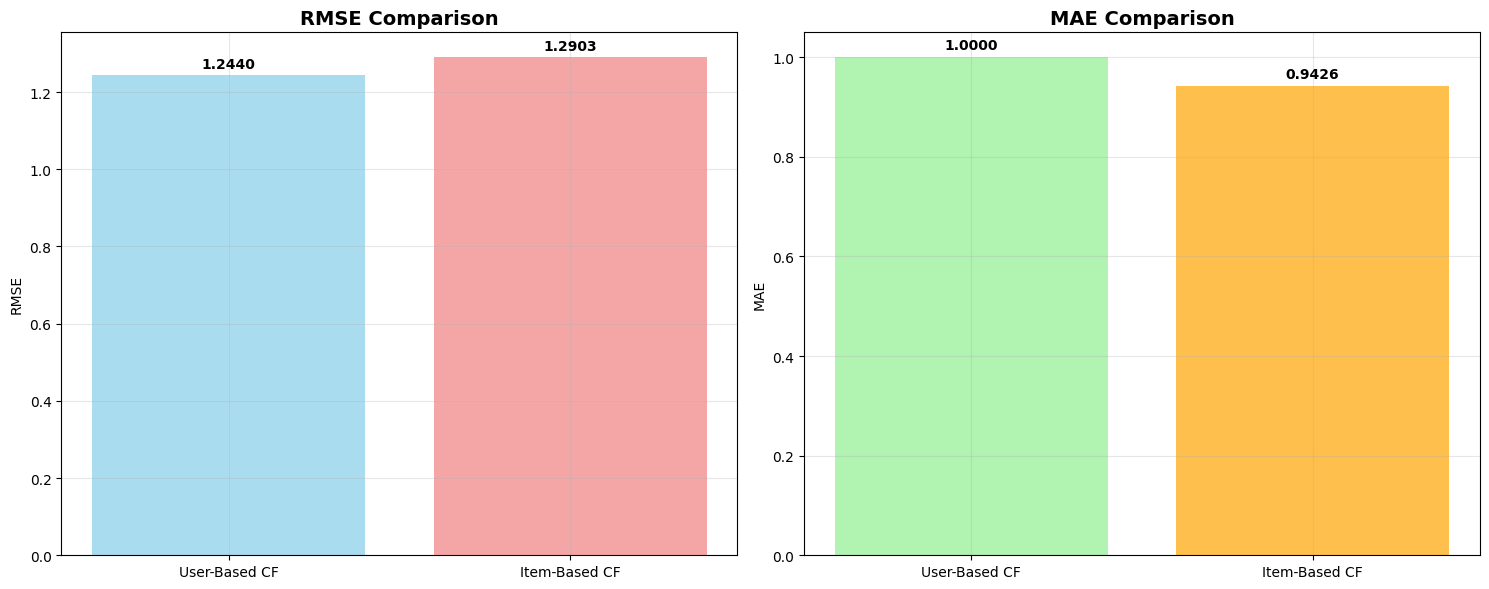

\n============================================================
🏆 WEEK 5 COLLABORATIVE FILTERING - FINAL RESULTS
\n📊 Model Performance Summary:
┌─────────────────┬──────────┬──────────┬────────────┐
│ Model           │   RMSE   │   MAE    │  Samples   │
├─────────────────┼──────────┼──────────┼────────────┤
│ User-Based CF   │   1.2440 │   1.0000 │         21 │
│ Item-Based CF   │   1.2903 │   0.9426 │         21 │
└─────────────────┴──────────┴──────────┴────────────┘
\n🏆 Winner: 🥇 User-Based CF
📈 Performance Improvement: 3.59%
\n✅ Week 5 Objectives Completed:
  ✅ User-Based Collaborative Filtering implemented
  ✅ Item-Based Collaborative Filtering implemented
  ✅ Performance comparison completed
  ✅ Both models ready for optimization


In [11]:
# Visualize results
if user_cf_results and item_cf_results:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # RMSE Comparison
    models = [user_cf_results['model_name'], item_cf_results['model_name']]
    rmse_values = [user_cf_results['rmse'], item_cf_results['rmse']]
    mae_values = [user_cf_results['mae'], item_cf_results['mae']]
    
    axes[0].bar(models, rmse_values, color=['skyblue', 'lightcoral'], alpha=0.7)
    axes[0].set_title('RMSE Comparison', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('RMSE')
    axes[0].grid(True, alpha=0.3)
    
    # Add values on bars
    for i, v in enumerate(rmse_values):
        axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # MAE Comparison
    axes[1].bar(models, mae_values, color=['lightgreen', 'orange'], alpha=0.7)
    axes[1].set_title('MAE Comparison', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('MAE')
    axes[1].grid(True, alpha=0.3)
    
    # Add values on bars
    for i, v in enumerate(mae_values):
        axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Summary comparison
    print("\\n" + "="*60)
    print("🏆 WEEK 5 COLLABORATIVE FILTERING - FINAL RESULTS")
    print("="*60)
    
    print(f"\\n📊 Model Performance Summary:")
    print(f"┌─────────────────┬──────────┬──────────┬────────────┐")
    print(f"│ Model           │   RMSE   │   MAE    │  Samples   │")
    print(f"├─────────────────┼──────────┼──────────┼────────────┤")
    print(f"│ User-Based CF   │ {user_cf_results['rmse']:8.4f} │ {user_cf_results['mae']:8.4f} │ {user_cf_results['n_samples']:10d} │")
    print(f"│ Item-Based CF   │ {item_cf_results['rmse']:8.4f} │ {item_cf_results['mae']:8.4f} │ {item_cf_results['n_samples']:10d} │")
    print(f"└─────────────────┴──────────┴──────────┴────────────┘")
    
    # Determine winner
    if user_cf_results['rmse'] < item_cf_results['rmse']:
        winner = "🥇 User-Based CF"
        improvement = ((item_cf_results['rmse'] - user_cf_results['rmse']) / item_cf_results['rmse']) * 100
    else:
        winner = "🥇 Item-Based CF"
        improvement = ((user_cf_results['rmse'] - item_cf_results['rmse']) / user_cf_results['rmse']) * 100
    
    print(f"\\n🏆 Winner: {winner}")
    print(f"📈 Performance Improvement: {improvement:.2f}%")
    
    print(f"\\n✅ Week 5 Objectives Completed:")
    print(f"  ✅ User-Based Collaborative Filtering implemented")
    print(f"  ✅ Item-Based Collaborative Filtering implemented") 
    print(f"  ✅ Performance comparison completed")
    print(f"  ✅ Both models ready for optimization")
    
else:
    print("⚠️  Evaluation failed - check model implementations")